## Processing coral presence ground truths for soft labelling and general tasks

In [1]:
%load_ext autoreload
%autoreload 2

# spatial
import geopandas as gpd
import xarray as xa
import rasterio
from rasterio import features
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# files
import os
import sys
from pathlib import Path

# general
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# custom
from coralshift.plotting import spatial_plots
from coralshift.processing import spatial_data
from coralshift.dataloading import config
from coralshift import functions_creche

In [45]:
FULL_LATS = [-32, 0]
FULL_LONS = [130, 170]

# restrict region further to visualise polygon rasterisation
LONS_LIM = [145.4, 146]
LATS_LIM = [-10.4, -9.9]

LONS_LARGE_LIM = [142, 145]
LATS_LARGE_LIM = [-13, -10]


RESOLUTION_LAT = RESOLUTION_LON = 15/3600

## UNEP-WCMC

In [3]:
# operating on remote
# load in shapefile to geopandas dataframe
# unep_fp = Path(config.gt_folder) / "unep-wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp" #idk why this didn't work
unep_fp = "data/ground_truth/unep_wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdf = gpd.read_file(unep_fp)
print(len(unep_gdf))
unep_gdf.head()

17504


,LAYER_NAME,METADATA_I,ORIG_NAME,FAMILY,GENUS,SPECIES,DATA_TYPE,START_DATE,END_DATE,DATE_TYPE,VERIF,NAME,LOC_DEF,SURVEY_MET,GIS_AREA_K,Shape_Leng,Shape_Area,REP_AREA_K,geometry
0,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,Coral line buffered to 300m,Not Reported,5.059916,0.152948,0.000420,Not Reported,"POLYGON ((46.47551 -11.97419, 46.47851 -11.978..."
1,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,Coral line buffered to 300m,Not Reported,5.450101,0.164919,0.000453,Not Reported,"POLYGON ((46.21811 -12.21430, 46.22181 -12.218..."
2,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,31/12/2009,-Y,Not Reported,Not Reported,coral,Not Reported,32.351025,1.079098,0.002664,Not Reported,"MULTIPOLYGON (((142.82287 -9.67503, 142.81353 ..."
3,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,coral,Not Reported,1.823247,0.066740,0.000159,Not Reported,"POLYGON ((36.90715 21.98134, 36.89960 21.98446..."
4,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,coral,Not Reported,34.815939,1.171056,0.003047,Not Reported,"MULTIPOLYGON (((36.93400 21.98049, 36.93382 21..."


(-10.4, -9.9)

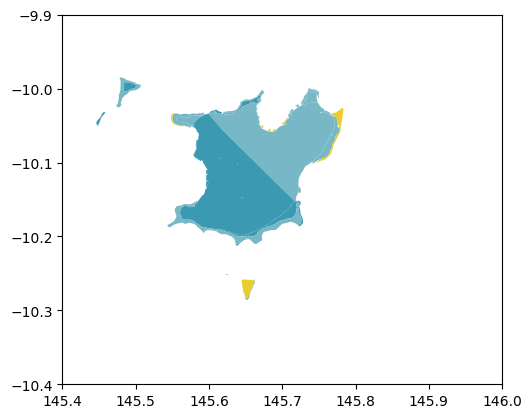

In [90]:
### visualise polygons

# limit table to GBR+ of interest.
# Often appears to plot out of range because some rows contain multiple polygons over a huge range
# Not sure what the association between these are. Satellite derivation? e.g. METADATA_I = 81.0
cs_unep_gdf = unep_gdf.cx[min(LONS_LIM)+0.9:max(LONS_LIM)-0.9, min(LATS_LIM):max(LATS_LIM)]
# plot each polygon in df a different color
colors = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#d83c04"]

cs_unep_gdf.geometry.plot(color=[colors[i//5] for i in range(len(cs_unep_gdf))])
plt.xlim(LONS_LIM)
plt.ylim(LATS_LIM)

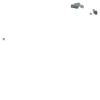

In [76]:
cs_unep_gdf.geometry.iloc[12]

In [18]:


# rasterise area
cs_unep_raster = functions_creche.rasterize_geodf(cs_unep_gdf, resolution_lat=resolution_lat, resolution_lon=resolution_lon)
cs_unep_raster_xa = functions_creche.raster_to_xarray(
    cs_unep_raster, x_y_limits=functions_creche.lat_lon_vals_from_geo_df(cs_unep_gdf)[:4], 
    resolution_lat=resolution_lat, resolution_lon=resolution_lon)



In [6]:
def shapely_to_linear_ring(shapely_geom):
    """
    Convert Shapely geometry to LinearRing or list of LinearRings for Polygon/MultiPolygon.
    """
    if isinstance(shapely_geom, sg.Polygon):
        return [sg.LinearRing(list(shapely_geom.exterior.coords))]
    elif isinstance(shapely_geom, sg.MultiPolygon):
        return [sg.LinearRing(list(poly.exterior.coords)) for poly in shapely_geom.geoms]
    else:
        raise ValueError("Unsupported geometry type")

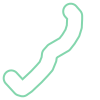

In [11]:
import shapely.geometry as sg
# xx, yy = cs_unep_gdf.iloc[4].geometry.exterior.coords.xy
# xs = xx.tolist()
# ys = yy.tolist()
# sg.LinearRing([(x, y) for x, y in zip(xs, ys)])

# fig = plt.figure(figsize=(10, 10))

# gs = fig.add_gridspec(1, 2)
# ax_poly = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
# ax_raster = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree()) # check unep projection

# # plot native polygon
# # cs_unep_gdf.iloc[:].geometry.plot(ax=ax_poly)

# # ax_poly.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.75)
# # ax_poly.add_geometries(cs_unep_gdf.iloc[:].geometry, crs=ccrs.PlateCarree())
# ax_poly.add_geometries([sg.LinearRing(cs_unep_gdf.iloc[4].geometry.exterior.coords)], crs=ccrs.PlateCarree())
# # spatial_plots.format_spatial_plot()

# # ax_poly.set_xlim(min(tight_area_lons), max(tight_area_lons))
# # ax_poly.set_ylim(min(tight_area_lats), max(tight_area_lats))
# ax_poly.set_xlim(min(xs), max(xs))
# ax_poly.set_ylim(min(ys), max(ys))
# # spatial_plots.plot_spatial(cs_unep_raster_xa, fax=(fig,ax_raster), cbar=False)

# for ax in [ax_poly, ax_raster]:
#     ax.set_xlim(min(tight_area_lons), max(tight_area_lons))
#     ax.set_ylim(min(tight_area_lats), max(tight_area_lats))

# ax_poly.set_title("Native polygon format")
# ax_raster.set_title("Rasterised")



# TODO: plot linear rings on rasters
# shapely_to_linear_ring(cs_unep_gdf.iloc[4].geometry)
sg.LinearRing(cs_unep_gdf.iloc[3].geometry.exterior.coords)

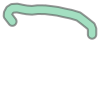

In [58]:
unep_gdf.geometry.iloc[7]

In [12]:
# resolution_lon, resolution_lat = 1, 1

# return df of only the reefs in the area within the bounds of full_lats and full_lons
unep_raster = functions_creche.rasterize_geodf(unep_gdf, resolution_lat=resolution_lat, resolution_lon=resolution_lon)
# normalise raster. Normalise to what value? Will be done eventually in ml preprocess, but interesting question
unep_norm_raster = unep_raster / unep_raster.max()

plt.imshow(unep_raster[1050:1150, 950:1050])
plt.colorbar()

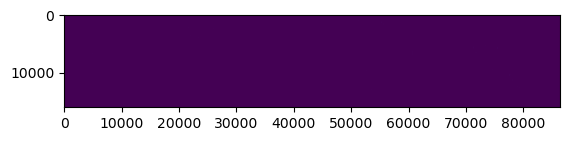

In [49]:
plt.imshow(unep_raster)

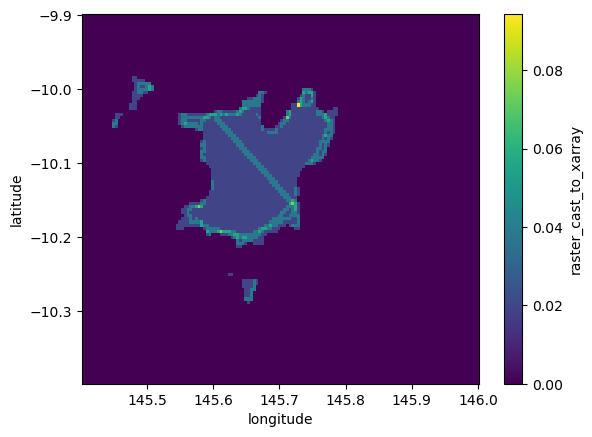

In [19]:
xa_unep = functions_creche.raster_to_xarray(
    unep_norm_raster, x_y_limits=functions_creche.lat_lon_vals_from_geo_df(unep_gdf)[:4], 
    resolution_lat=resolution_lat, resolution_lon=resolution_lon)
# Plot the xarray DataArray
xa_unep.sel(latitude=slice(min(LATS_LIM), max(LATS_LIM)), longitude=slice(min(LONS_LIM), max(LONS_LIM))).plot()

In [15]:
gebco_fp = (
    Path(config.bathymetry_folder) / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc"
)
gebco_xa = spatial_data.process_xa_d(xa.open_dataset(gebco_fp))
gebco_xa.latitude.values[:5]

array([-39.99791667, -39.99375   , -39.98958333, -39.98541667,
       -39.98125   ])

In [32]:
# depth limits
depth_lims = [-50, 20]

# generate limited and remove nan coloration
xa_unep.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))
xa_unep_lim = xa_unep.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))
nan_xa_unep = xa_unep.where(xa_unep != 0, np.nan)

# mask gebco and create limited version
shallow_masked_gebco = gebco_xa["elevation"].where((gebco_xa["elevation"] < max(depth_lims)) & (gebco_xa["elevation"] > min(depth_lims)), np.nan)
gebco_xa_lim = shallow_masked_gebco.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))

# gbr_xa_unep = xa_unep.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))
gbr_norm_nan_xa_unep = (xa_unep / np.nanmax(xa_unep)).where(xa_unep != 0, np.nan)


(<Figure size 1000x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Rasterised UNEP Reef Presence'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f08036c8a50>)

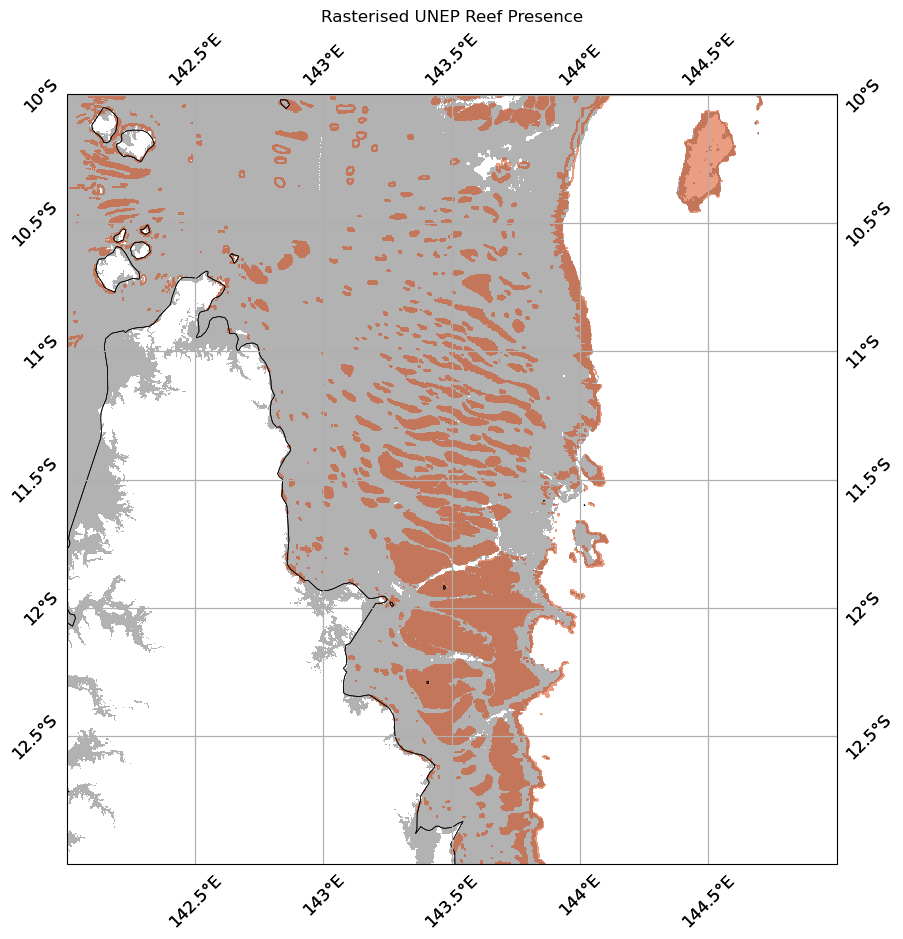

In [91]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

spatial_plots.plot_spatial(
    shallow_masked_gebco.sel(latitude=slice(min(LATS_LARGE_LIM),max(LATS_LARGE_LIM)),longitude=slice(min(LONS_LARGE_LIM),max(LONS_LARGE_LIM))), 
    title=None, cbar=False, presentation=False, fax=(fig, ax), alpha=0.3, cmap_type = ["#000000", "#000000"])

spatial_plots.plot_spatial(
    gbr_norm_nan_xa_unep.sel(latitude=slice(min(LATS_LARGE_LIM),max(LATS_LARGE_LIM)),longitude=slice(min(LONS_LARGE_LIM),max(LONS_LARGE_LIM))), 
    title="Rasterised UNEP Reef Presence", cbar=False, presentation=False, fax=(fig, ax), cmap_type = ["#d83c04", "#d83c04"],
    alpha=0.5)

(<Figure size 1000x1000 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x148e7bdb5060>)

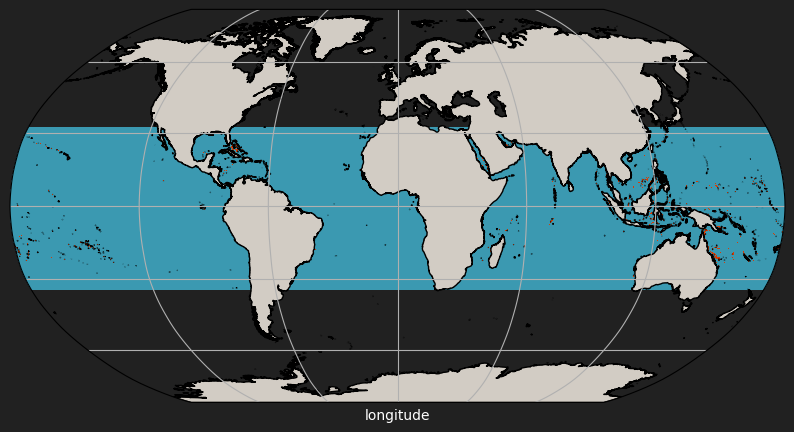

In [ ]:
spatial_plots.plot_spatial(
    xa_unep, title="Rasterised UNEP Reef Presence", orient_colorbar="horizontal", presentation=True, map_proj=ccrs.Robinson())

## Reef Check 

In [ ]:
# load in substrate. Will need to change data location. Can I use a URL?
# check out environment consistencies: want to use mamba and delete others

# this could be useful: https://annefou.github.io/metos_python/04-plotting/

# read in spreadsheet.
# DATES NOT PARSING PROPERLY
substrate_csv = pd.read_csv("data/ground_truth/reef_check/Substrate.csv.crdownload",
    parse_dates=["date"], 
    # date_format="%d-%B-%y"
    )

substrate_csv.head()

/tmp/ipykernel_1494038/903097137.py:8: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  substrate_csv = pd.read_csv("data/ground_truth/reef_check/Substrate.csv.crdownload",
/tmp/ipykernel_1494038/903097137.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  substrate_csv = pd.read_csv("data/ground_truth/reef_check/Substrate.csv.crdownload",


,site_id,survey_id,static_descriptors_reef_id (archived field),reef_name,country,state_province_island,city_town,region,coordinates_in_decimal_degree_format,longitude_degrees,...,latitude_cardinal_direction,year,date,depth (m),substrate_code,segment_code,total,substrate_recorded_by,errors,what_errors
0,6a8719bb-91fe-46c1-9635-37fb1f022ea9,000887f9-b8c4-4c43-bc63-700c0e8b385b,119.18.33.5E.11.0.57.5N,Masigasig/Esteban Reef,Philippines,Palawan,Taytay,Indo-Pacific,"11.015972, 119.309306",119,...,N,2016,2016-04-20,3.0,HC,S1,22,NaN,False,NaN
1,6a8719bb-91fe-46c1-9635-37fb1f022ea9,000887f9-b8c4-4c43-bc63-700c0e8b385b,119.18.33.5E.11.0.57.5N,Masigasig/Esteban Reef,Philippines,Palawan,Taytay,Indo-Pacific,"11.015972, 119.309306",119,...,N,2016,2016-04-20,3.0,HC,S2,25,NaN,False,NaN
2,6a8719bb-91fe-46c1-9635-37fb1f022ea9,000887f9-b8c4-4c43-bc63-700c0e8b385b,119.18.33.5E.11.0.57.5N,Masigasig/Esteban Reef,Philippines,Palawan,Taytay,Indo-Pacific,"11.015972, 119.309306",119,...,N,2016,2016-04-20,3.0,HC,S3,27,NaN,False,NaN
3,6a8719bb-91fe-46c1-9635-37fb1f022ea9,000887f9-b8c4-4c43-bc63-700c0e8b385b,119.18.33.5E.11.0.57.5N,Masigasig/Esteban Reef,Philippines,Palawan,Taytay,Indo-Pacific,"11.015972, 119.309306",119,...,N,2016,2016-04-20,3.0,HC,S4,26,NaN,False,NaN
4,6a8719bb-91fe-46c1-9635-37fb1f022ea9,000887f9-b8c4-4c43-bc63-700c0e8b385b,119.18.33.5E.11.0.57.5N,Masigasig/Esteban Reef,Philippines,Palawan,Taytay,Indo-Pacific,"11.015972, 119.309306",119,...,N,2016,2016-04-20,3.0,HC/B,S1,0,NaN,False,NaN


In [ ]:
substrate_csv.columns

Index(['site_id', 'survey_id', 'static_descriptors_reef_id (archived field)',
       'reef_name', 'country', 'state_province_island', 'city_town', 'region',
       'coordinates_in_decimal_degree_format', 'longitude_degrees',
       'longitude_minutes', 'longitude_seconds',
       'longitude_cardinal_direction', 'latitude_degrees', 'latitude_minutes',
       'latitude_seconds', 'latitude_cardinal_direction', 'year', 'date',
       'depth (m)', 'substrate_code', 'segment_code', 'total',
       'substrate_recorded_by', 'errors', 'what_errors'],
      dtype='object')

In [ ]:
# make working copy: not sure how necessary this is
df_substrate = substrate_csv

In [ ]:
substrate_csv.total.iloc[0]

# some entries in "total" column are "O" rather than "0"!
df_substrate.total.replace("O", "0")
df_substrate["total"] = pd.to_numeric(df_substrate['total'], errors='coerce').fillna(0).astype('int64')


In [ ]:
# would a function be necessary here? When are they necessary for such specific data processing tasks???

# make working copy: not sure how necessary this is
df_substrate = substrate_csv
# df_substrate.date = pd.to_datetime(df_substrate.date, format="%d-%B-%y")

# Split the column on the comma
split_series = df_substrate["coordinates_in_decimal_degree_format"].str.split(',')

# strip any leading/trailing spaces
split_series = split_series.apply(lambda x: [(val.strip()) for val in x])

# convert to float if possible
out = split_series[:].apply(lambda x: [functions_creche.try_convert_to_float(val.strip()) for val in x])

# write to separate columns in df
df_substrate[["lat_decimal", "lon_decimal"]] = pd.DataFrame(out.to_list(), index=df_substrate.index)

In [ ]:
# nans aren't the same
print("lon_decimal nans:", sum(df_substrate["lon_decimal"].isna()))
print("lat_decimal nans:", sum(df_substrate["lat_decimal"].isna()))

# remove all rows containing a nan in either of these two columns
df_substrate_processed = df_substrate.dropna(subset=["lon_decimal", "lat_decimal"])

lon_decimal nans: 1716
lat_decimal nans: 1612


In [ ]:
df_substrate_processed.date

0        2016-04-20
1        2016-04-20
2        2016-04-20
3        2016-04-20
4        2016-04-20
            ...    
800327   2004-07-27
800328   2004-07-27
800329   2004-07-27
800330   2004-07-27
800331   2004-07-27
Name: date, Length: 798616, dtype: datetime64[ns]

/tmp/ipykernel_1494038/1917432746.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


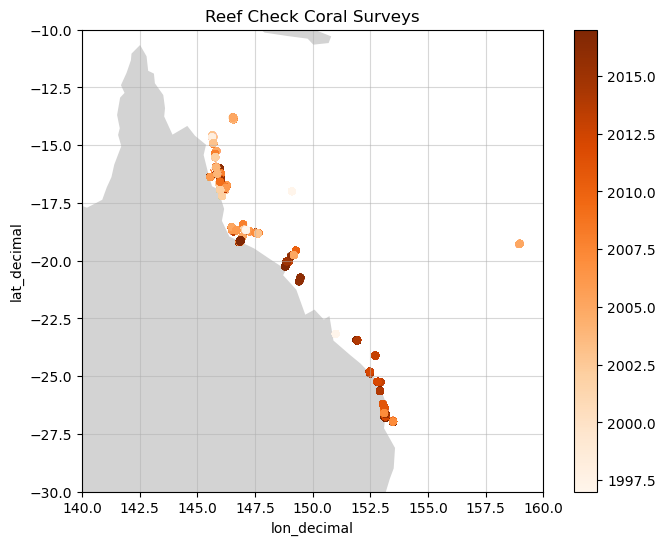

In [ ]:
# limit df to lats/lons of interest
df_substrate_gbr = df_substrate_processed[
    df_substrate_processed.lon_decimal.between(142,159) & df_substrate_processed.lat_decimal.between(-27,-10)
    ]

import geopandas as gpd
from matplotlib.dates import date2num
import matplotlib.pyplot as plt


# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
# countries[countries["name"] == "Australia"].plot(color="lightgrey",
#                                                  ax=ax)
countries.plot(color="lightgrey",ax=ax)
# plot points
df_substrate_gbr.plot(x="lon_decimal", y="lat_decimal", kind="scatter", c=(df_substrate_gbr['year']),
    colormap="Oranges", title="Reef Check Coral Surveys", ax=ax)

ax.set_xlim([140,160])
ax.set_ylim([-30,-10])

ax.grid(alpha=0.5)
plt.show()

<GeoAxes: title={'center': 'Reef Check Coral Surveys'}, xlabel='lon_decimal', ylabel='lat_decimal'>

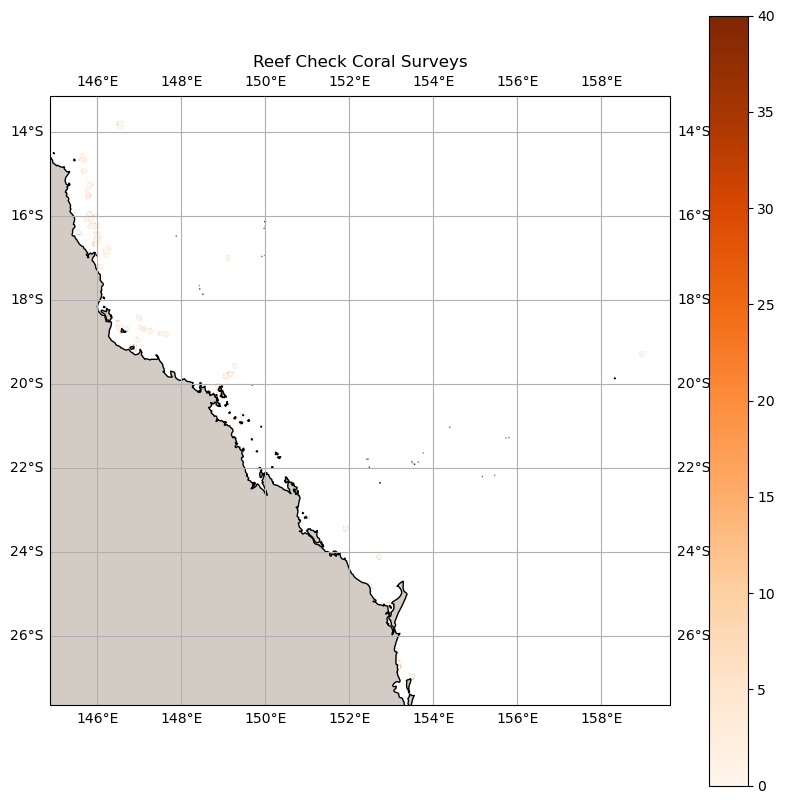

In [ ]:
df = df_substrate_gbr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection=ccrs.PlateCarree())

# plot as points
ax.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "10m", edgecolor="k", facecolor="#d2ccc4"
    )
)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

first_month = df["date"].min().strftime("%b %Y")
last_month = df["date"].max().strftime("%b %Y")


df.plot(x="lon_decimal", y="lat_decimal", kind="scatter", s=5, c=df["total"], cmap="Oranges",
        title="Reef Check Coral Surveys", ax=ax)

(<Figure size 1000x1000 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f73039b4510>)

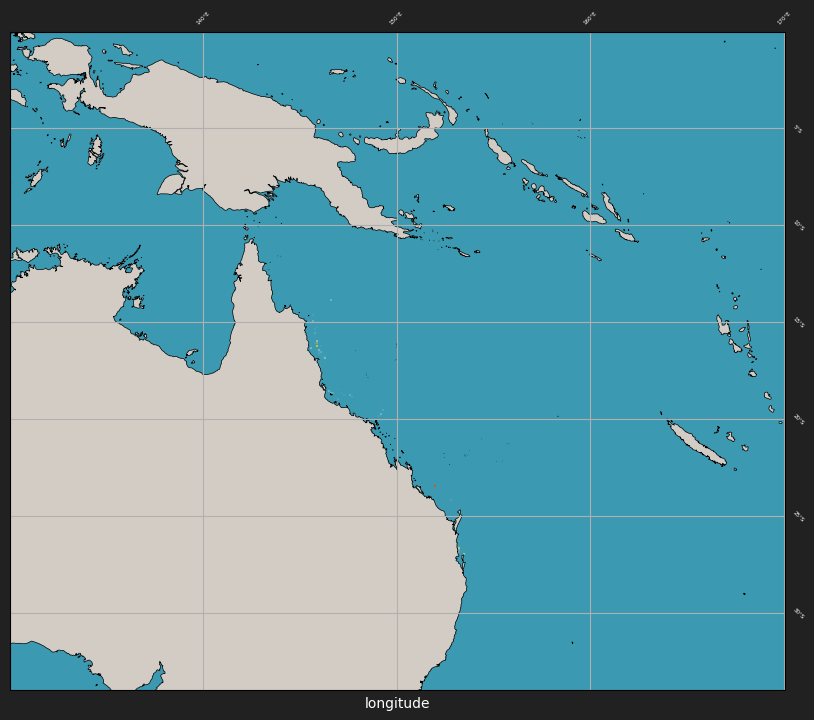

In [ ]:
substrate_raster = functions_creche.rasterise_points_df(
    df_substrate_gbr, "lat_decimal", "lon_decimal", resolution_lat=resolution_lat, resolution_lon=resolution_lon)
substrate_xarray = functions_creche.raster_to_xarray(
    substrate_raster, resolution_lat=resolution_lat, resolution_lon=resolution_lon, x_y_limits=[-180,-90,180,90])

spatial_plots.plot_spatial(
    substrate_xarray.sel(latitude=slice(min(full_lats),max(full_lats)), longitude=slice(min(full_lons),max(full_lons))),
    title="Rasterised Reef Check coral presence survey data", orient_colorbar="horizontal", presentation=True)

In [ ]:
substrate_xarray

<xarray.DataArray 'raster_cast_to_xarray' (latitude: 1800, longitude: 3600)>
dask.array<getitem, shape=(1800, 3600), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude    (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
    spatial_ref  int64 0

## Allen Coral Atlas

In [35]:
# read in ACA GBR gpkg file
# aca_gbr = gpd.read_file("lustre_scratch/datasets/ground_truths/allen_coral_atlas/GBR/Benthic-Map/benthic.gpkg")

import dask_geopandas
import geopandas as gpd
import pandas as pd
from coralshift.dataloading import config
from coralshift import functions_creche
import dask

benthic_fps = [Path(config.gt_folder) / "allen_coral_atlas/GBR_TS/Benthic-Map/benthic.gpkg",
    Path(config.gt_folder) / "allen_coral_atlas/EPNG/Benthic-Map/benthic.gpkg",
    Path(config.gt_folder) / "allen_coral_atlas/misc/Benthic-Map/benthic.gpkg",
]
# input_geopackages = [Path("allen_coral_atlas/GBR/Benthic-Map/benthic.gpkg")]

benthic_dfs = []
for benthic_fp in benthic_fps:
    dask_gpd = dask_geopandas.read_file(benthic_fp, npartitions=4)
    # select coral
    gpd_coral = dask_gpd[dask_gpd["class"] == "Coral/Algae"]
    benthic_dfs.append(gpd_coral)

aca_coral = dask.dataframe.multi.concat(benthic_dfs)


In [36]:
# lon_resolution, lat_resolution = 0.1, 0.1
# this can take a while
aca_coral_raster = functions_creche.rasterize_geodf(aca_coral, resolution_lat=resolution_lat, resolution_lon=resolution_lon)
aca_norm_raster = aca_coral_raster / aca_coral_raster.max()

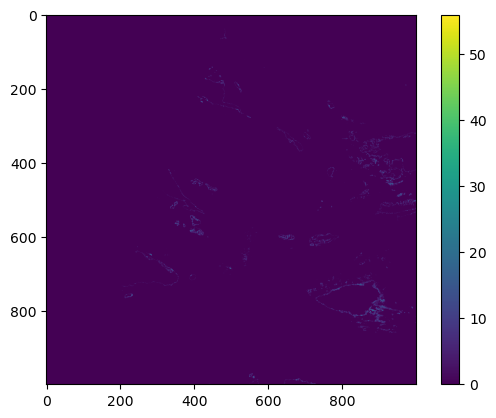

In [37]:
plt.imshow(aca_coral_raster[:1000,:1000])
plt.colorbar()

Text(0.5, 0.98, 'Normalised coral raster')

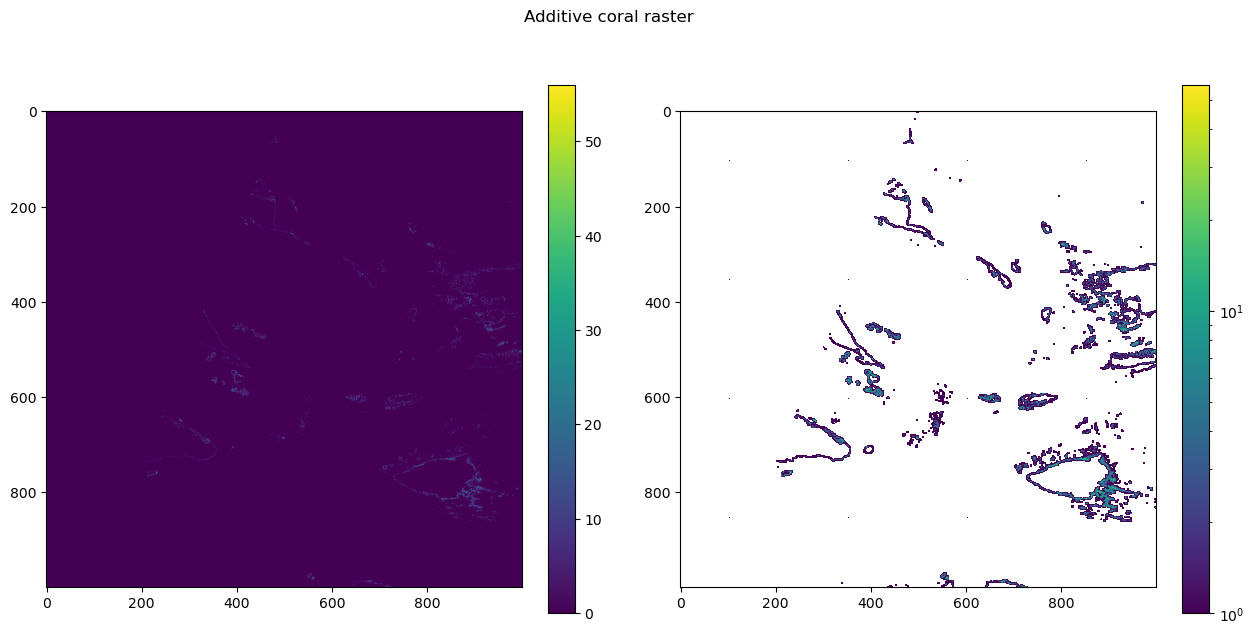

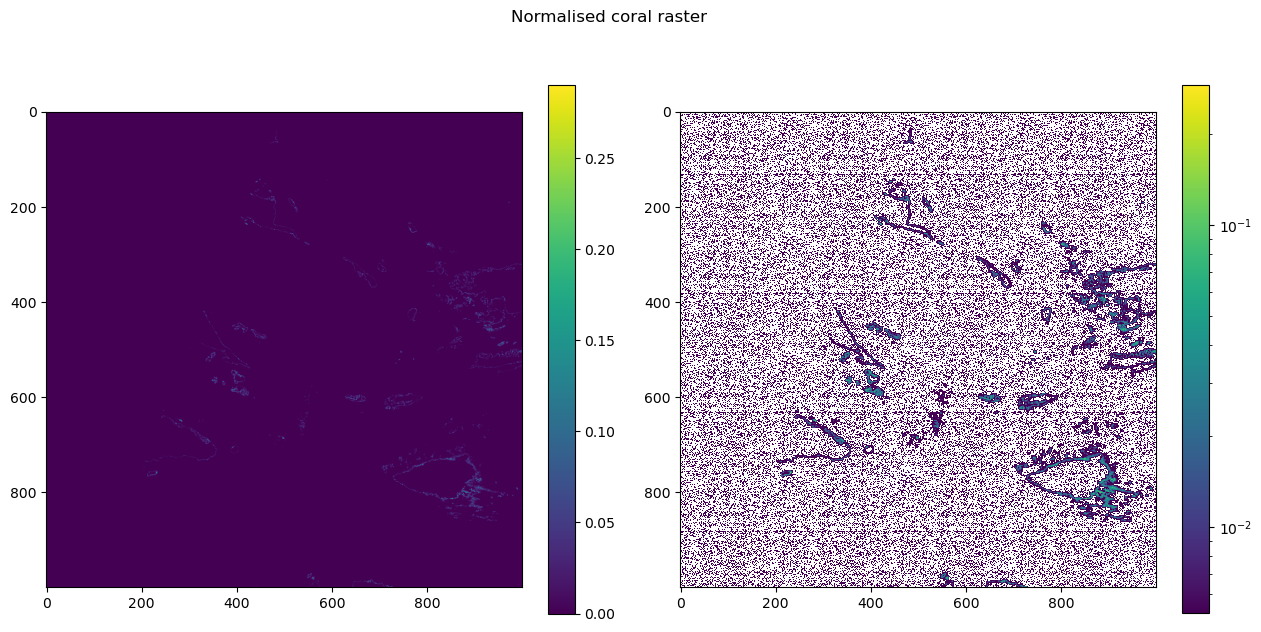

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))

normal_ax = ax[0].imshow(aca_coral_raster[:1000,:1000])
log_ax = ax[1].imshow(aca_coral_raster[:1000,:1000], norm="log")
plt.colorbar(normal_ax, ax=ax[0], fraction=0.05)
plt.colorbar(log_ax, ax=ax[1], fraction=0.05)
plt.suptitle("Additive coral raster")


fig, ax = plt.subplots(ncols=2, figsize=(15, 7))

normal_ax = ax[0].imshow(aca_norm_raster[:1000,:1000])
log_ax = ax[1].imshow(aca_norm_raster[:1000,:1000], norm="log")
plt.colorbar(normal_ax, ax=ax[0], fraction=0.05)
plt.colorbar(log_ax, ax=ax[1], fraction=0.05)
plt.suptitle("Normalised coral raster")


# ax[0].colorbar()
# ax[1].colorbar()

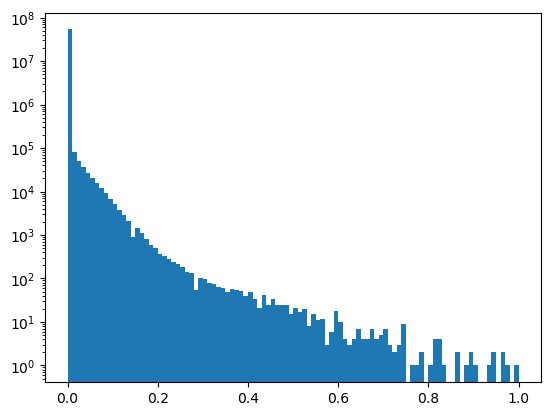

In [ ]:
plt.hist(aca_norm_raster.flatten(), 100)
plt.yscale("log")

In [ ]:
aca_coral_bounds = functions_creche.lat_lon_vals_from_geo_df(aca_coral.compute())
xa_aca = spatial_data.process_xa_d(
    functions_creche.raster_to_xarray(aca_norm_raster, aca_coral_bounds[:4], resolution_lat=resolution_lat, resolution_lon=resolution_lon))

In [ ]:
xa_aca

<xarray.DataArray 'raster_cast_to_xarray' (latitude: 6144, longitude: 8705)>
dask.array<rechunk-merge, shape=(6144, 8705), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -24.27 -24.27 -24.26 ... 1.323 1.327 1.332
  * longitude  (longitude) float64 126.7 126.7 126.7 126.7 ... 162.9 162.9 163.0
Attributes:
    crs:      EPSG:4326

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'raster_cast_to_xarray at 0.0042° (~452 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f013e9eaa50>)

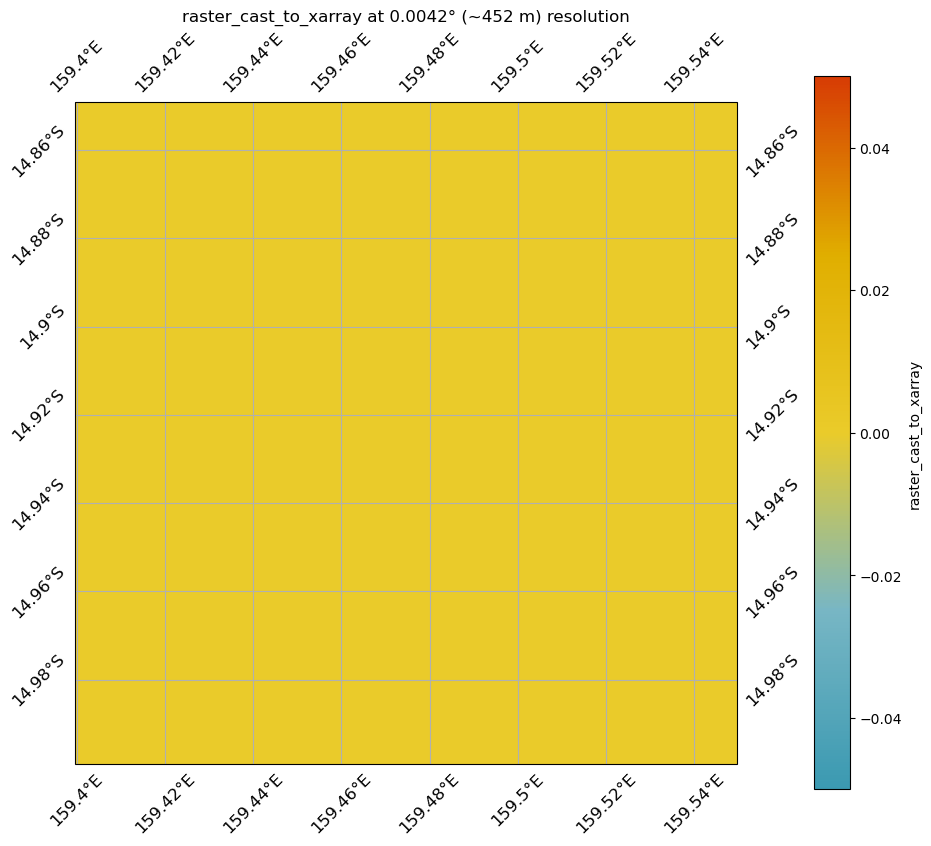

In [ ]:
lat_sel = [-15,-14.85]
lon_sel = [159.4,159.55]


spatial_plots.plot_spatial(
    xa_aca.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))))

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'Rasterised ACA GBR Coral/Algae\nat {lat_resolution} degree resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f38f228a7d0>)

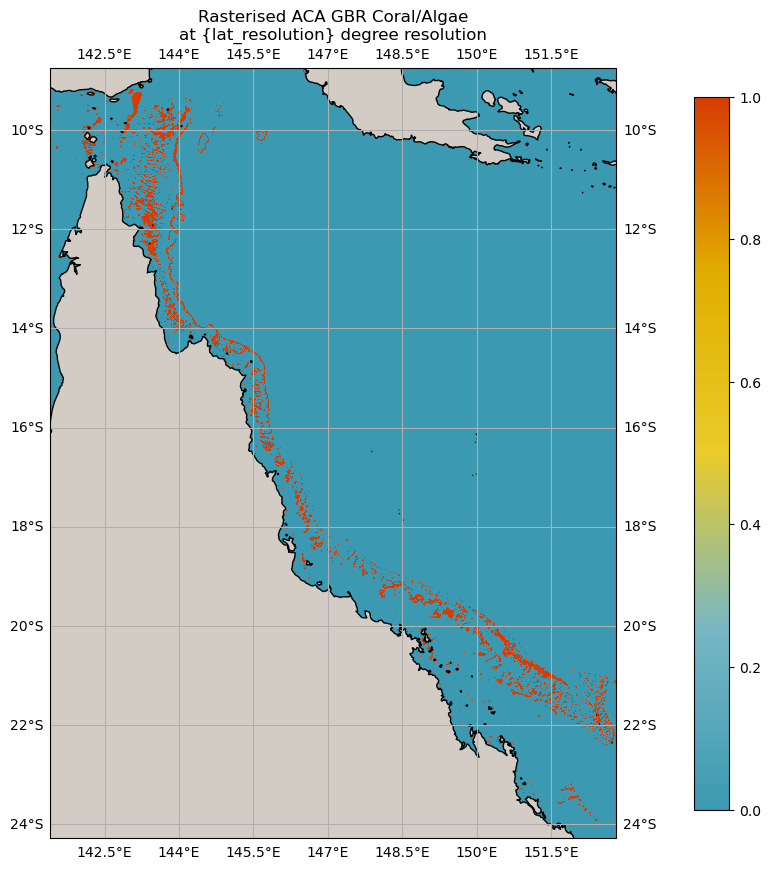

In [ ]:
spatial_plots.plot_spatial(xa_aca, title=f"Rasterised ACA Coral/Algae\nat {lat_resolution} degree resolution")

## XL Catlin

In [ ]:
# load in spreadsheet
catlin_atl_csv_p = Path(config.gt_folder) / "xl_catlin/seaviewsurvey_reefcover_atlantic.csv"
catlin_atl_df = pd.read_csv(catlin_atl_csv_p)
catlin_atl_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/ground_truth/xl_catlin/seaviewsurvey_reefcover_atlantic.csv'

In [ ]:
# TODO: use regional classifications
# for each region, determine which class labels correspond to coral: "Hard Coral" and "Soft Coral"

# load in class label info
catlin_labels_csv_p = Path("xl_catlin/seaviewsurvey_labelsets.csv")
catlin_labels_df = pd.read_csv(catlin_labels_csv_p)

coral_func_groups = ["Hard Coral", "Soft Coral"]

coral_labels_df = catlin_labels_df[catlin_labels_df["func_group"].isin(coral_func_groups)]
coral_labels = coral_labels_df["label"].to_list()


In [ ]:
# collate necessary survey files

dir_path = Path("xl_catlin")
reefcover_csvs = list(dir_path.glob("**/*reefcover*.csv"))

dfs = []
for csv in reefcover_csvs:
    reefcover_df = pd.read_csv(csv)
    dfs.append(reefcover_df)

reefcover_df = pd.concat(dfs, ignore_index=True)
meta_columns = reefcover_df.columns[:5].tolist()
catlin_coral_df = reefcover_df[meta_columns + coral_labels]

# sum all coral columns in each row, ignoring first five columns
catlin_coral_df["total_coral"] = catlin_coral_df.iloc[:, 5:].sum(axis=1)

catlin_coral_df.head()

/tmp/ipykernel_484/238052782.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catlin_coral_df["total_coral"] = catlin_coral_df.iloc[:, 5:].sum(axis=1)


,surveyid,imageid,quadratid,lat,lng,ACER,AGAR,APAL,CNAT,DLAB,...,POCI_CAU,POR_Com_fi,POR_Com_fu,POR_EP_B,POR_NOD,POR_OTH_EP,POR-MASS,POR-MASS-B,PVAR,total_coral
0,10001,100010007,10001000701,-16.189056,145.898116,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.78
1,10001,100010007,10001000702,-16.189056,145.898116,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.90
2,10001,100010008,10001000801,-16.189075,145.898118,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.96
3,10001,100010008,10001000802,-16.189075,145.898118,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,0.86
4,10001,100010008,10001000803,-16.189075,145.898118,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.84


In [ ]:
# this is incredibly fast – rasterising points much quicker than polygons
lat_resolution, lon_resolution = 0.001, 0.001

# cast to raster
catlin_coral_raster = rasterise_points_df(
    catlin_coral_df, "lat", "lng", lat_resolution=lat_resolution, lon_resolution=lon_resolution)
# convert raster to xarray
catlin_coral_xa = raster_to_xarray(
    catlin_coral_raster, lat_resolution=lat_resolution, lon_resolution=lon_resolution, x_y_limits=[-180, -90, 180, 90])

In [ ]:
catlin_coral_xa

<xarray.DataArray (latitude: 180000, longitude: 360000)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * latitude   (latitude) float64 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    crs:      EPSG:4326

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'Rasterised Catlin Coral Cover Lowres'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f3832cb3880>)

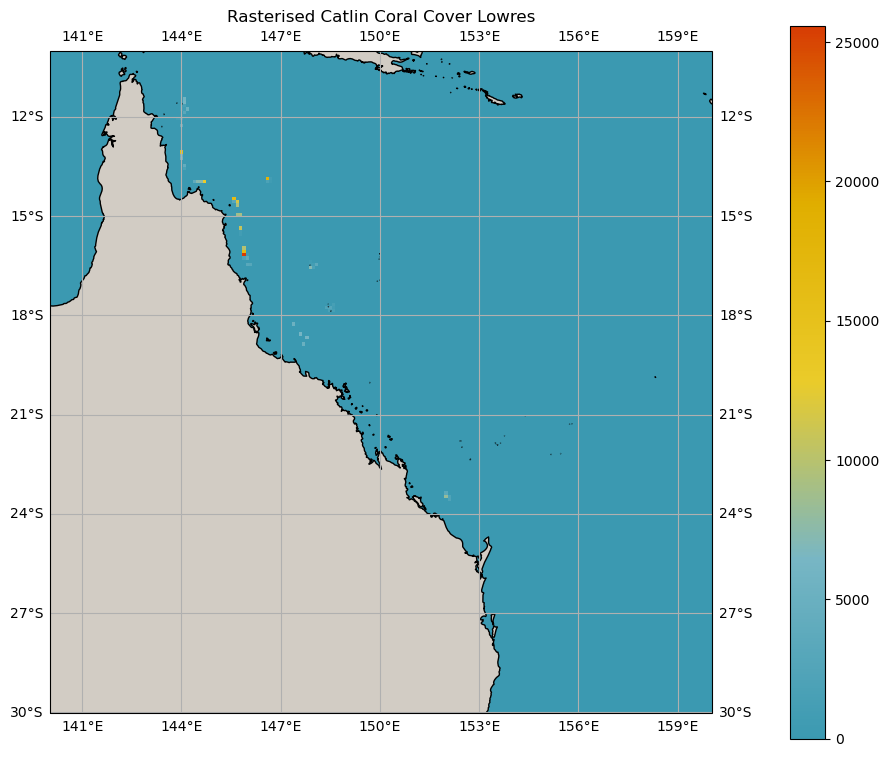

In [ ]:
# cast to raster
catlin_coral_raster_lowres = rasterise_points_df(
    catlin_coral_df, "lat", "lng", lat_resolution=0.1, lon_resolution=0.1)
# convert raster to xarray
catlin_coral_xa_lowres = raster_to_xarray(
    catlin_coral_raster_lowres, lat_resolution=0.1, lon_resolution=0.1, x_y_limits=[-180, -90, 180, 90])
spatial_plots.plot_spatial(catlin_coral_xa_lowres.sel(latitude=slice(-10,-30), longitude=slice(140,160)), title="Rasterised Catlin Coral Cover Lowres")


(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'Rasterised Catlin Coral Cover'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f398eb1fa90>)

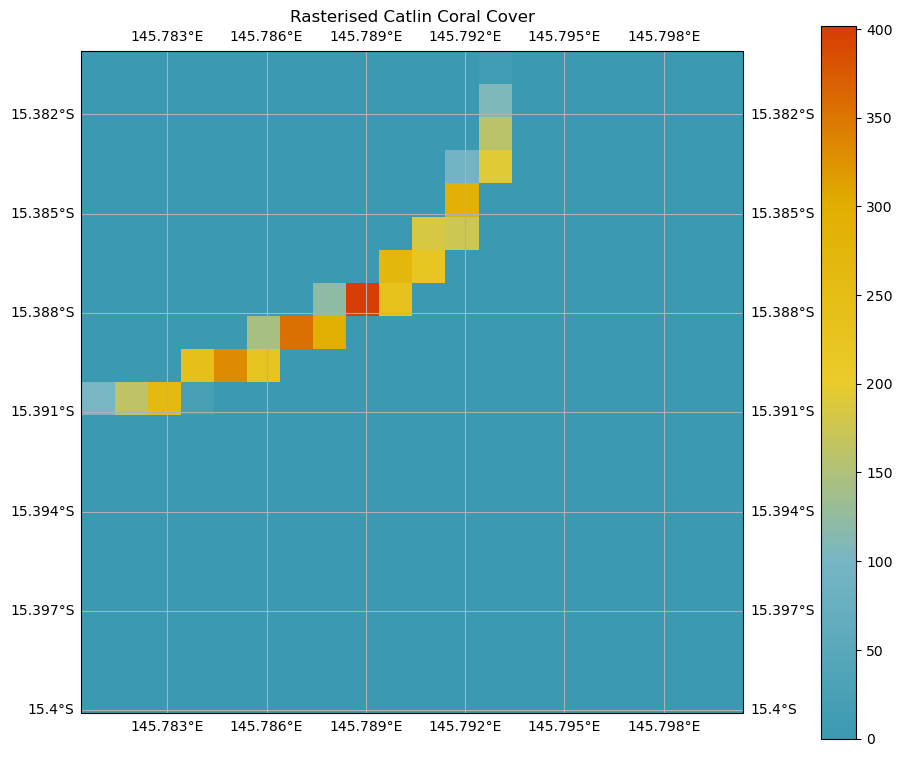

In [ ]:
spatial_plots.plot_spatial(catlin_coral_xa.sel(latitude=slice(-15.38,-15.4), longitude=slice(145.78,145.8)), title="Rasterised Catlin Coral Cover")
# ax.set_xlim([140,150])
# ax.set_ylim([-30,0])

## Generate ground truth comparisons for presentation


In [ ]:
# declare region
lat_sel = [-20, -19]
lon_sel = [148, 150]

(<Figure size 1000x1000 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x1491dab2ed70>)

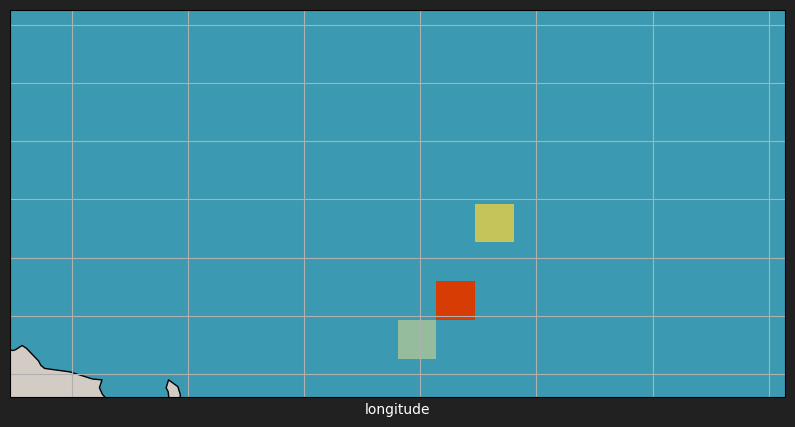

In [ ]:
spatial_plots.plot_spatial(
    substrate_xarray.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))), presentation=True)

(<Figure size 1000x1000 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x1492444715d0>)

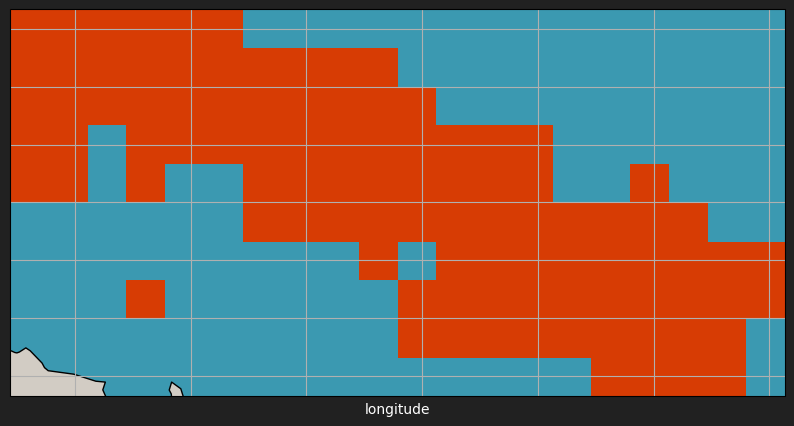

In [ ]:
spatial_plots.plot_spatial(
    xa_aca.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    presentation=True)

In [ ]:
xa_unep

<xarray.DataArray 'raster_cast_to_xarray' (latitude: 668, longitude: 3599)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * latitude   (latitude) float64 32.51 32.41 32.31 32.21 ... -34.1 -34.2 -34.3
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Attributes:
    crs:      EPSG:4326

(<Figure size 1000x1000 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x148e7c9aedd0>)

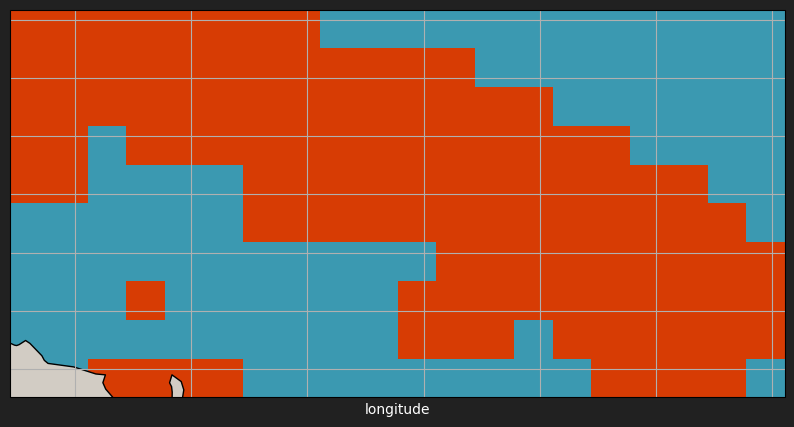

In [ ]:
spatial_plots.plot_spatial(
    xa_unep.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    presentation=True)

In [ ]:
spatial_plots.plot_spatial(
    catlin_coral_xa.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    presentation=True)

### Graveyard

In [ ]:
# from rasterio import features
# out = features.rasterize(geom[:], out_shape=(40, 180), all_touched=True, merge_alg=features.MergeAlg.replace, transform=rasterio.Affine(0.1, 0, 0, 0, -0.1, 0))
# plt.imshow(out)

###

# from geocube.api.core import make_geocube
# import rasterio as rio

# # must be a better way to organise this!!
# input_gpkg_p = Path("allen_coral_atlas/GBR/Benthic-Map/benthic.gpkg")

# out_grid = make_geocube(
#     vector_data=input_gpkg_p,
#     resolution=(-1, 1),
# )